# Exploratory Data Analysis
## Predicting Daily Searches for Food Delivery

This notebook explores the relationship between weather, time features, and daily search estimates for food delivery services.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Data Loading


In [3]:
# Load UberEats data
url = "https://raw.githubusercontent.com/cedricly-git/BADS_Capstone_repo/main/Data/ubereats+time_related_vars.csv"
uber = pd.read_csv(url)

# Convert Day to datetime
uber['Day'] = pd.to_datetime(uber['Day'])

print("UberEats Data Shape:", uber.shape)
print("\nFirst few rows:")
uber.head()


UberEats Data Shape: (728, 10)

First few rows:


,Day,trend_value,weight,total_ubereats,estimated_daily_searches,weekday,is_weekend,is_holiday,month,season
0,2023-11-13,35,0.003880,236627,918,Monday,0,0,November,Fall
1,2023-11-14,52,0.005765,236676,1364,Tuesday,0,0,November,Fall
2,2023-11-15,74,0.008204,232238,1905,Wednesday,0,0,November,Fall
3,2023-11-16,44,0.004878,233488,1139,Thursday,0,0,November,Fall
4,2023-11-17,53,0.005876,258156,1517,Friday,0,0,November,Fall


In [4]:
# Load weather data for top 10 most populated cities in Switzerland
# Using population-weighted approach to represent country-wide behavior
cities = {
    "Zurich": {"lat": 47.3769, "lon": 8.5417, "pop": 436551},
    "Geneva": {"lat": 46.2044, "lon": 6.1432, "pop": 209061},
    "Basel": {"lat": 47.5596, "lon": 7.5886, "pop": 177571},
    "Lausanne": {"lat": 46.5197, "lon": 6.6323, "pop": 144873},
    "Bern": {"lat": 46.9481, "lon": 7.4474, "pop": 137995},
    "Winterthur": {"lat": 47.5056, "lon": 8.7247, "pop": 120376},
    "Lucerne": {"lat": 47.0502, "lon": 8.3064, "pop": 86234},
    "St. Gallen": {"lat": 47.4245, "lon": 9.3767, "pop": 78863},
    "Lugano": {"lat": 46.0101, "lon": 8.9600, "pop": 63629},
    "Biel": {"lat": 47.1404, "lon": 7.2471, "pop": 56896}
}

# Calculate population weights
total_pop = sum(city["pop"] for city in cities.values())
city_weights = {name: city["pop"] / total_pop for name, city in cities.items()}

print("City Population Weights:")
print("=" * 50)
for city, weight in sorted(city_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{city:12s}: {weight*100:5.2f}% (pop: {cities[city]['pop']:,})")
print(f"\nTotal population covered: {total_pop:,}")

start_date = "2023-11-13"
end_date = "2025-11-11"

weather_data = []

# Loop through cities
print(f"\nFetching weather data for {len(cities)} cities...")
for city, coords in cities.items():
    url1 = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=Europe/Zurich"
    )
    data = requests.get(url1).json()
    for i, date in enumerate(data['daily']['time']):
        weather_data.append({
            "Day": datetime.strptime(date, "%Y-%m-%d"),
            "City": city,
            "Temp_Max": data['daily']['temperature_2m_max'][i],
            "Temp_Min": data['daily']['temperature_2m_min'][i],
            "Precipitation": data['daily']['precipitation_sum'][i]
        })
    print(f"  ✓ {city}")

weather_df = pd.DataFrame(weather_data)
print(f"\nWeather Data Shape: {weather_df.shape}")
print(f"Date range: {weather_df['Day'].min().date()} to {weather_df['Day'].max().date()}")
weather_df.head()


City Population Weights:
Zurich      : 28.87% (pop: 436,551)
Geneva      : 13.83% (pop: 209,061)
Basel       : 11.74% (pop: 177,571)
Lausanne    :  9.58% (pop: 144,873)
Bern        :  9.13% (pop: 137,995)
Winterthur  :  7.96% (pop: 120,376)
Lucerne     :  5.70% (pop: 86,234)
St. Gallen  :  5.22% (pop: 78,863)
Lugano      :  4.21% (pop: 63,629)
Biel        :  3.76% (pop: 56,896)

Total population covered: 1,512,049

Fetching weather data for 10 cities...
  ✓ Zurich
  ✓ Geneva
  ✓ Basel
  ✓ Lausanne
  ✓ Bern
  ✓ Winterthur
  ✓ Lucerne
  ✓ St. Gallen
  ✓ Lugano
  ✓ Biel

Weather Data Shape: (7300, 5)
Date range: 2023-11-13 to 2025-11-11


,Day,City,Temp_Max,Temp_Min,Precipitation
0,2023-11-13,Zurich,15.3,9.6,7.4
1,2023-11-14,Zurich,14.4,9.4,40.7
2,2023-11-15,Zurich,10.8,5.2,7.6
3,2023-11-16,Zurich,11.1,3.6,13.8
4,2023-11-17,Zurich,10.7,4.4,12.2


In [5]:
# Calculate population-weighted average weather for each day
# This represents country-wide weather based on major cities
print("Calculating population-weighted average weather...")
weather_df['pop_weight'] = weather_df['City'].map(city_weights)

# Calculate weighted averages
weather_avg = weather_df.groupby('Day').apply(
    lambda x: pd.Series({
        'Temp_Max': (x['Temp_Max'] * x['pop_weight']).sum(),
        'Temp_Min': (x['Temp_Min'] * x['pop_weight']).sum(),
        'Precipitation': (x['Precipitation'] * x['pop_weight']).sum()
    })
).reset_index()

print(f"Weighted average weather shape: {weather_avg.shape}")
print("\nSample of weighted averages:")
print(weather_avg.head())

# Also calculate simple average for comparison
weather_simple_avg = weather_df.groupby('Day').agg({
    'Temp_Max': 'mean',
    'Temp_Min': 'mean',
    'Precipitation': 'mean'
}).reset_index()
weather_simple_avg.columns = ['Day', 'Temp_Max_simple', 'Temp_Min_simple', 'Precipitation_simple']

# Merge weighted averages with UberEats data
df = pd.merge(uber, weather_avg, on='Day', how='left')

# Merge simple averages for comparison
df = pd.merge(df, weather_simple_avg, on='Day', how='left')

# Add derived features
df["temp_range"] = df["Temp_Max"] - df["Temp_Min"]
df["dayofweek"] = df["Day"].dt.weekday
df["month_num"] = df["Day"].dt.month
df["year"] = df["Day"].dt.year

print(f"\nMerged Dataset Shape: {df.shape}")
print("\nMissing values:")
print(df.isnull().sum())
print("\nFirst few rows:")
df.head()


Calculating population-weighted average weather...
Weighted average weather shape: (730, 4)

Sample of weighted averages:
         Day   Temp_Max  Temp_Min  Precipitation
0 2023-11-13  15.290495  9.222737       8.711186
1 2023-11-14  14.429246  9.680857      38.881935
2 2023-11-15  11.347257  5.223258       3.938751
3 2023-11-16  11.652487  2.855796      12.194031
4 2023-11-17  10.170269  4.144674       9.513213

Merged Dataset Shape: (728, 20)

Missing values:
Day                         0
trend_value                 0
weight                      0
total_ubereats              0
estimated_daily_searches    0
weekday                     0
is_weekend                  0
is_holiday                  0
month                       0
season                      0
Temp_Max                    0
Temp_Min                    0
Precipitation               0
Temp_Max_simple             0
Temp_Min_simple             0
Precipitation_simple        0
temp_range                  0
dayofweek               

,Day,trend_value,weight,total_ubereats,estimated_daily_searches,weekday,is_weekend,is_holiday,month,season,Temp_Max,Temp_Min,Precipitation,Temp_Max_simple,Temp_Min_simple,Precipitation_simple,temp_range,dayofweek,month_num,year
0,2023-11-13,35,0.003880,236627,918,Monday,0,0,November,Fall,15.290495,9.222737,8.711186,15.10,8.66,8.63,6.067758,0,11,2023
1,2023-11-14,52,0.005765,236676,1364,Tuesday,0,0,November,Fall,14.429246,9.680857,38.881935,14.28,9.25,38.51,4.748388,1,11,2023
2,2023-11-15,74,0.008204,232238,1905,Wednesday,0,0,November,Fall,11.347257,5.223258,3.938751,11.58,5.17,3.06,6.123999,2,11,2023
3,2023-11-16,44,0.004878,233488,1139,Thursday,0,0,November,Fall,11.652487,2.855796,12.194031,11.55,2.64,11.21,8.796691,3,11,2023
4,2023-11-17,53,0.005876,258156,1517,Friday,0,0,November,Fall,10.170269,4.144674,9.513213,10.21,4.06,8.87,6.025595,4,11,2023


### Comparison: Population-Weighted vs Simple Average


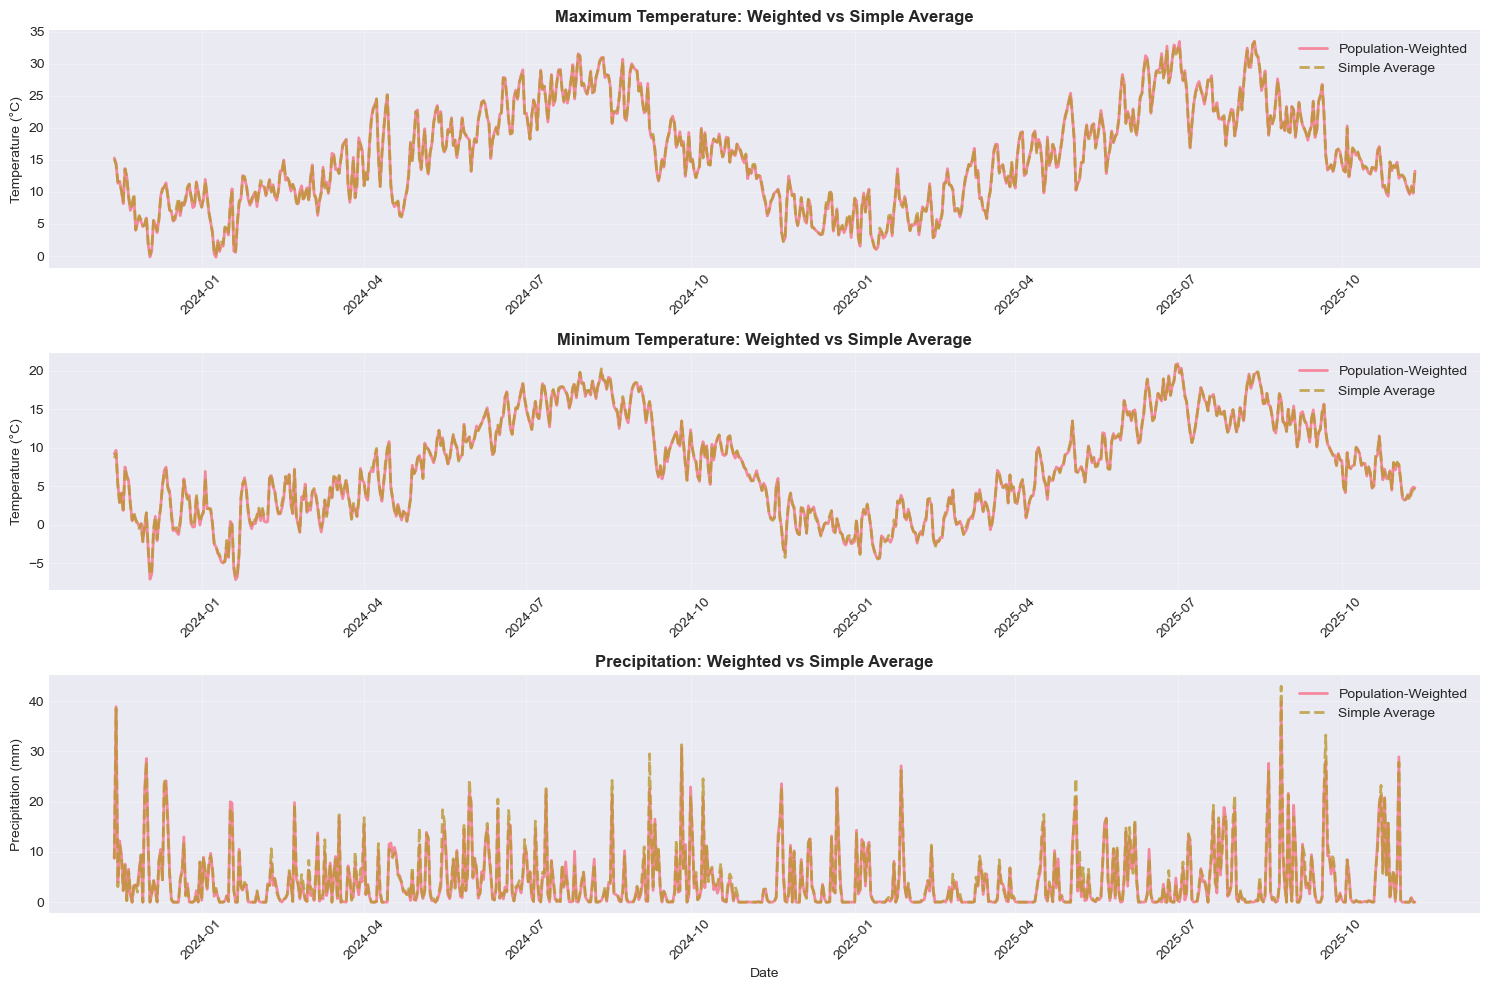

Difference Statistics (Weighted - Simple Average):
Temp_Max - Mean difference: -0.001°C
Temp_Max - Max difference: 0.931°C
Temp_Min - Mean difference: -0.053°C
Temp_Min - Max difference: 0.803°C
Precipitation - Mean difference: -0.221mm
Precipitation - Max difference: 7.818mm

Using population-weighted averages for analysis (more representative of country-wide behavior)


In [6]:
# Compare population-weighted vs simple average
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Temperature Max comparison
axes[0].plot(df['Day'], df['Temp_Max'], label='Population-Weighted', linewidth=2, alpha=0.8)
axes[0].plot(df['Day'], df['Temp_Max_simple'], label='Simple Average', linewidth=2, alpha=0.8, linestyle='--')
axes[0].set_title('Maximum Temperature: Weighted vs Simple Average', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Temperature Min comparison
axes[1].plot(df['Day'], df['Temp_Min'], label='Population-Weighted', linewidth=2, alpha=0.8)
axes[1].plot(df['Day'], df['Temp_Min_simple'], label='Simple Average', linewidth=2, alpha=0.8, linestyle='--')
axes[1].set_title('Minimum Temperature: Weighted vs Simple Average', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Precipitation comparison
axes[2].plot(df['Day'], df['Precipitation'], label='Population-Weighted', linewidth=2, alpha=0.8)
axes[2].plot(df['Day'], df['Precipitation_simple'], label='Simple Average', linewidth=2, alpha=0.8, linestyle='--')
axes[2].set_title('Precipitation: Weighted vs Simple Average', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Precipitation (mm)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate differences
print("Difference Statistics (Weighted - Simple Average):")
print("=" * 60)
print(f"Temp_Max - Mean difference: {(df['Temp_Max'] - df['Temp_Max_simple']).mean():.3f}°C")
print(f"Temp_Max - Max difference: {(df['Temp_Max'] - df['Temp_Max_simple']).abs().max():.3f}°C")
print(f"Temp_Min - Mean difference: {(df['Temp_Min'] - df['Temp_Min_simple']).mean():.3f}°C")
print(f"Temp_Min - Max difference: {(df['Temp_Min'] - df['Temp_Min_simple']).abs().max():.3f}°C")
print(f"Precipitation - Mean difference: {(df['Precipitation'] - df['Precipitation_simple']).mean():.3f}mm")
print(f"Precipitation - Max difference: {(df['Precipitation'] - df['Precipitation_simple']).abs().max():.3f}mm")

# Note: We'll use population-weighted averages going forward
print("\n" + "=" * 60)
print("Using population-weighted averages for analysis (more representative of country-wide behavior)")


## 2. Target Variable Analysis
### estimated_daily_searches


Target Variable: estimated_daily_searches
count     728.000000
mean     2777.001374
std      1065.388770
min       660.000000
25%      2053.000000
50%      2635.500000
75%      3353.250000
max      6222.000000
Name: estimated_daily_searches, dtype: float64

Skewness: 0.71
Kurtosis: 0.35


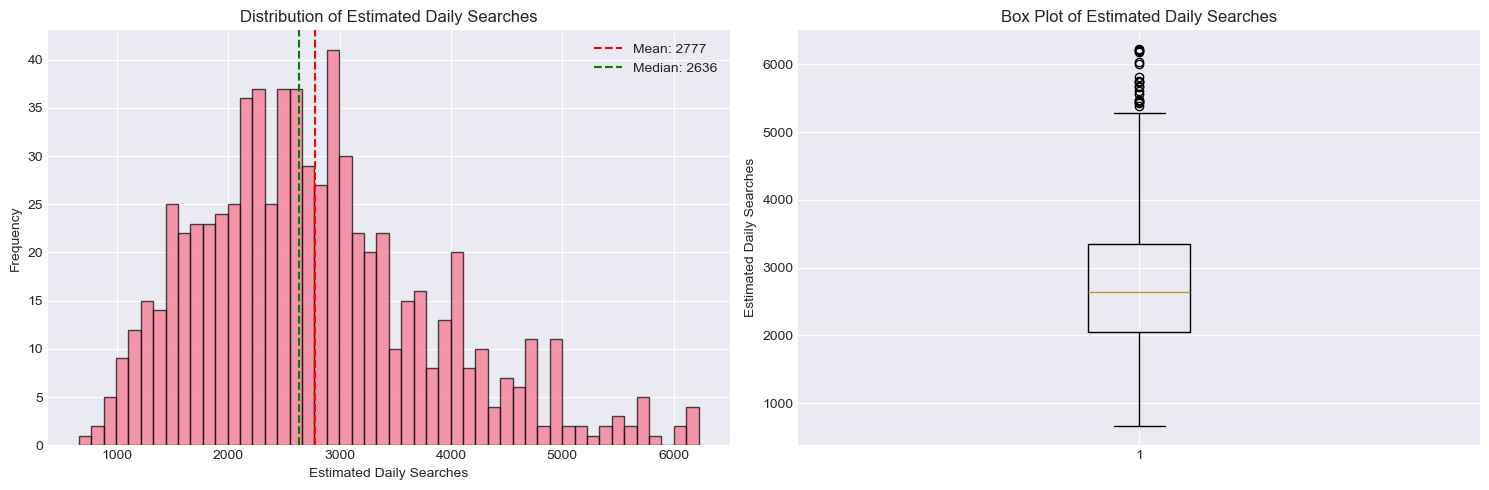

In [7]:
# Basic statistics for target variable
print("Target Variable: estimated_daily_searches")
print("=" * 50)
print(df['estimated_daily_searches'].describe())
print(f"\nSkewness: {df['estimated_daily_searches'].skew():.2f}")
print(f"Kurtosis: {df['estimated_daily_searches'].kurtosis():.2f}")

# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['estimated_daily_searches'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Estimated Daily Searches')
axes[0].set_xlabel('Estimated Daily Searches')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['estimated_daily_searches'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["estimated_daily_searches"].mean():.0f}')
axes[0].axvline(df['estimated_daily_searches'].median(), color='green', linestyle='--', 
                label=f'Median: {df["estimated_daily_searches"].median():.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['estimated_daily_searches'], vert=True)
axes[1].set_title('Box Plot of Estimated Daily Searches')
axes[1].set_ylabel('Estimated Daily Searches')

plt.tight_layout()
plt.show()


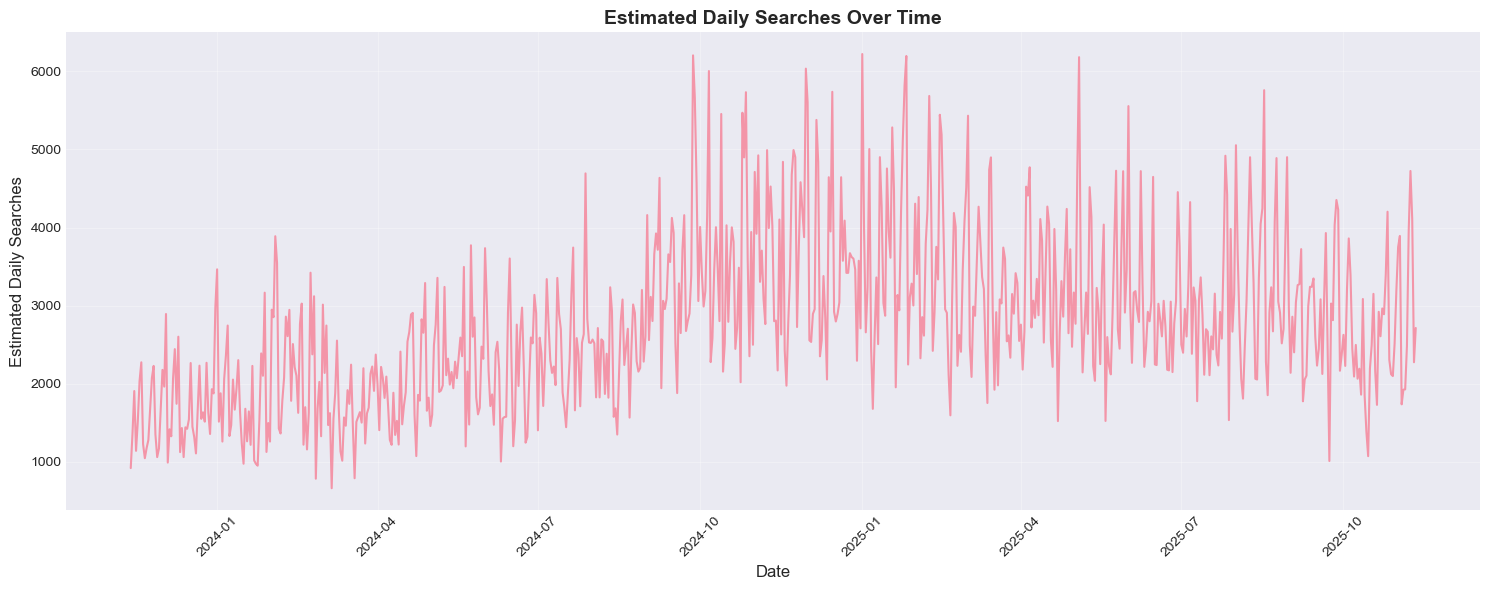

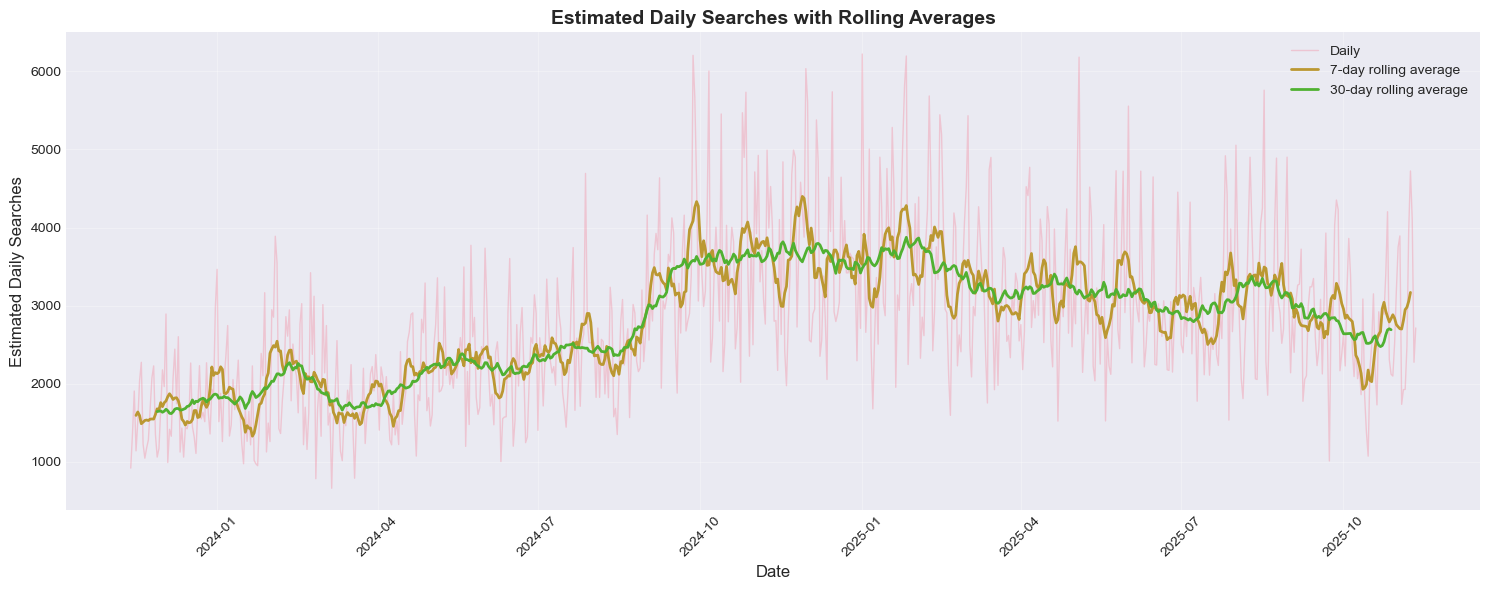

In [8]:
# Time series plot of target variable
plt.figure(figsize=(15, 6))
plt.plot(df['Day'], df['estimated_daily_searches'], linewidth=1.5, alpha=0.7)
plt.title('Estimated Daily Searches Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Estimated Daily Searches', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Rolling average
df_sorted = df.sort_values('Day')
df_sorted['rolling_7d'] = df_sorted['estimated_daily_searches'].rolling(window=7, center=True).mean()
df_sorted['rolling_30d'] = df_sorted['estimated_daily_searches'].rolling(window=30, center=True).mean()

plt.figure(figsize=(15, 6))
plt.plot(df_sorted['Day'], df_sorted['estimated_daily_searches'], alpha=0.3, label='Daily', linewidth=1)
plt.plot(df_sorted['Day'], df_sorted['rolling_7d'], label='7-day rolling average', linewidth=2)
plt.plot(df_sorted['Day'], df_sorted['rolling_30d'], label='30-day rolling average', linewidth=2)
plt.title('Estimated Daily Searches with Rolling Averages', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Estimated Daily Searches', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Weather Features Analysis


In [9]:
# Weather statistics
weather_cols = ['Temp_Max', 'Temp_Min', 'Precipitation', 'temp_range']
print("Weather Features Summary Statistics")
print("=" * 60)
print(df[weather_cols].describe())


Weather Features Summary Statistics
         Temp_Max    Temp_Min  Precipitation  temp_range
count  728.000000  728.000000     728.000000  728.000000
mean    15.650000    7.510134       4.120004    8.139866
std      7.728857    6.388908       6.005504    2.983303
min     -0.180210   -7.115929       0.000000    1.901997
25%      9.581851    2.025079       0.062188    6.030811
50%     15.012170    7.234590       1.524528    7.570281
75%     21.389781   12.748850       5.645146   10.237786
max     33.494154   20.922637      39.880750   16.115764


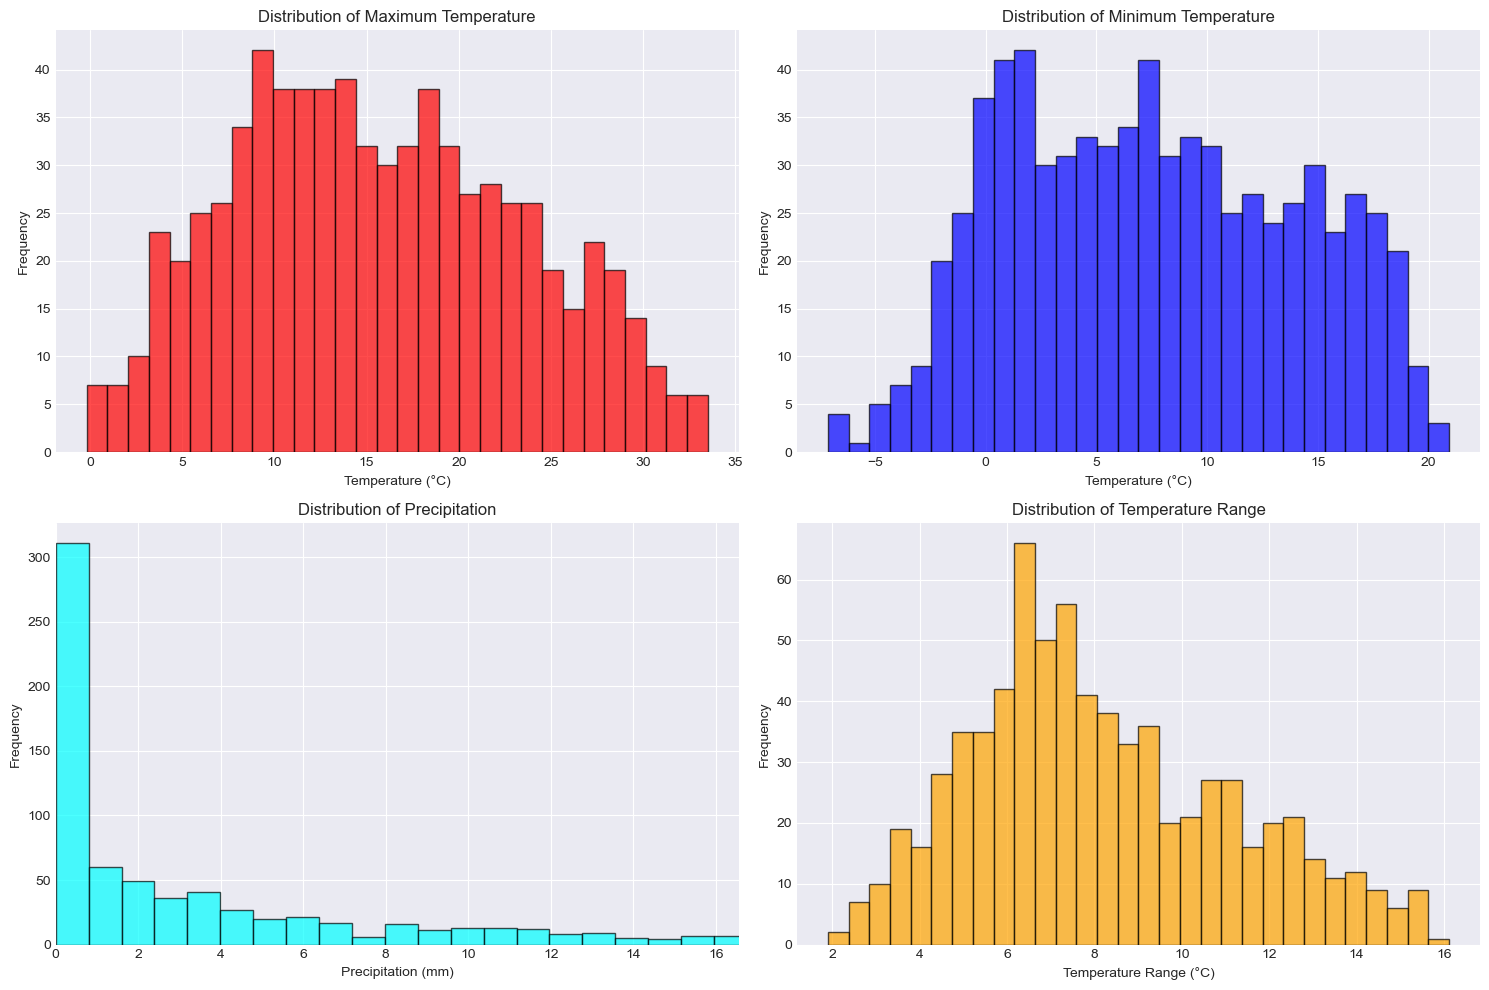

In [10]:
# Distribution of weather features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['Temp_Max'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0, 0].set_title('Distribution of Maximum Temperature')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['Temp_Min'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_title('Distribution of Minimum Temperature')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df['Precipitation'], bins=50, edgecolor='black', alpha=0.7, color='cyan')
axes[1, 0].set_title('Distribution of Precipitation')
axes[1, 0].set_xlabel('Precipitation (mm)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, df['Precipitation'].quantile(0.95))  # Remove extreme outliers for better visualization

axes[1, 1].hist(df['temp_range'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Distribution of Temperature Range')
axes[1, 1].set_xlabel('Temperature Range (°C)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


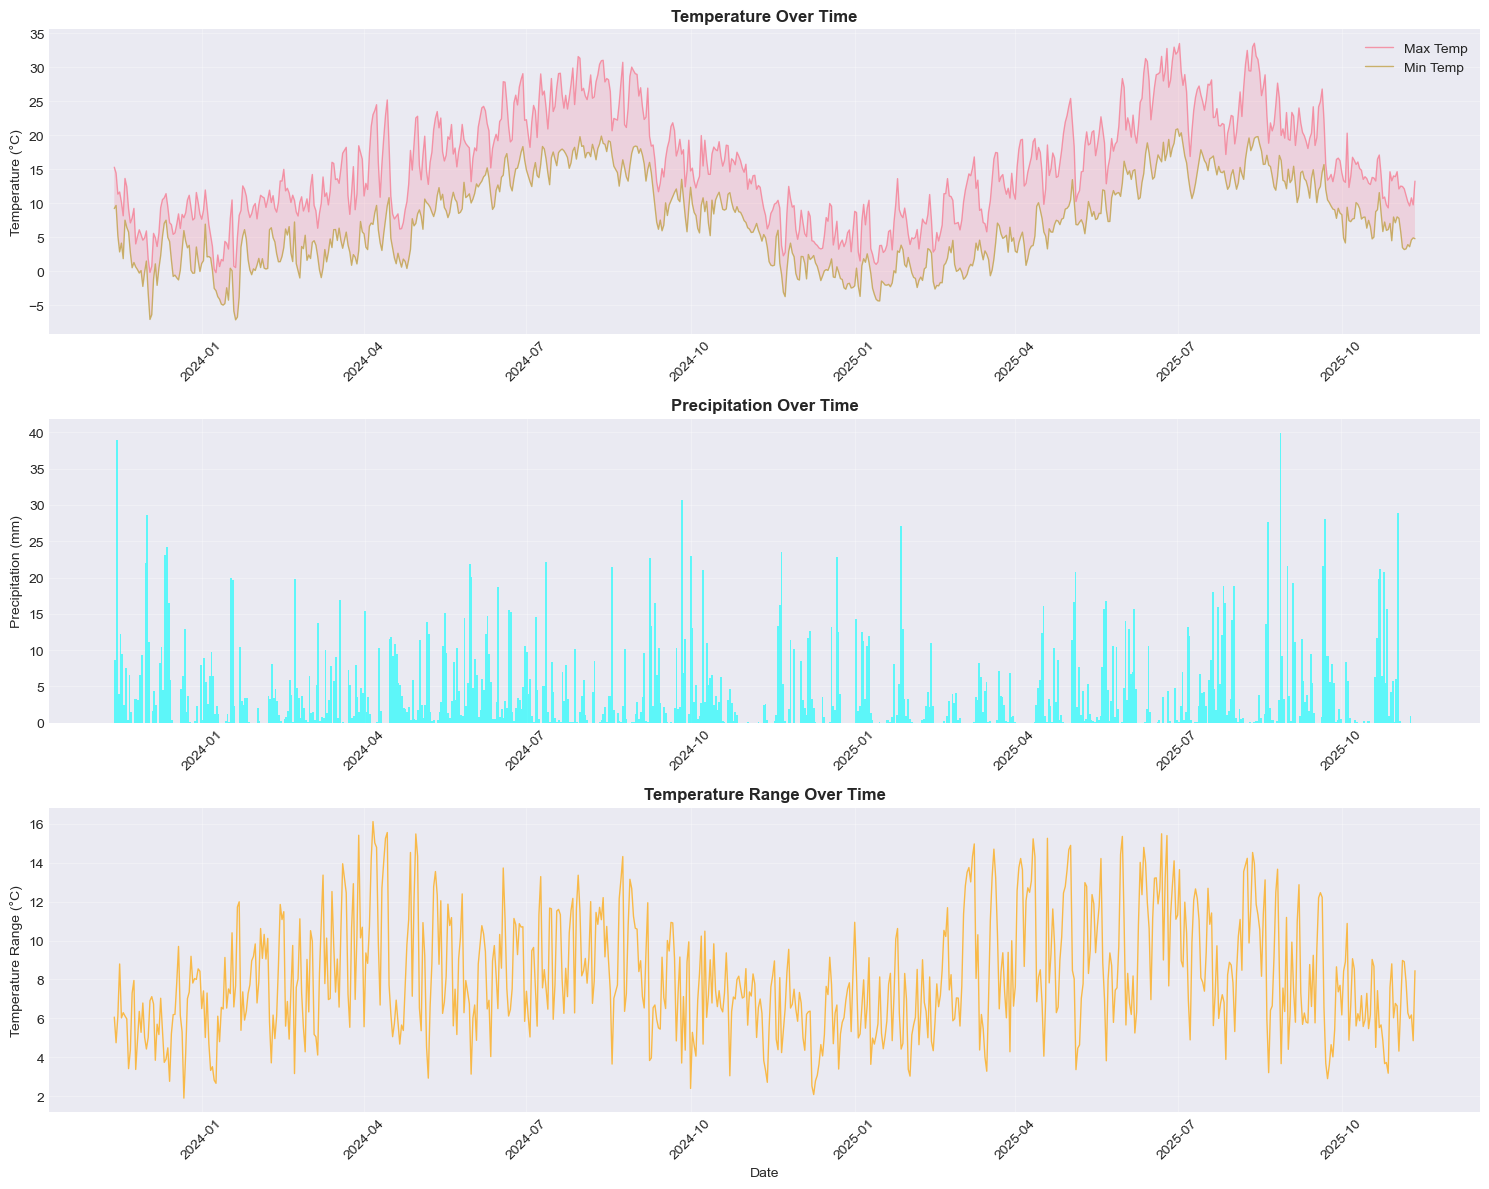

In [11]:
# Weather over time
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

axes[0].plot(df['Day'], df['Temp_Max'], label='Max Temp', alpha=0.7, linewidth=1)
axes[0].plot(df['Day'], df['Temp_Min'], label='Min Temp', alpha=0.7, linewidth=1)
axes[0].fill_between(df['Day'], df['Temp_Min'], df['Temp_Max'], alpha=0.2)
axes[0].set_title('Temperature Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(df['Day'], df['Precipitation'], width=1, alpha=0.6, color='cyan')
axes[1].set_title('Precipitation Over Time', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precipitation (mm)')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

axes[2].plot(df['Day'], df['temp_range'], alpha=0.7, linewidth=1, color='orange')
axes[2].set_title('Temperature Range Over Time', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Temperature Range (°C)')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Time Features Analysis


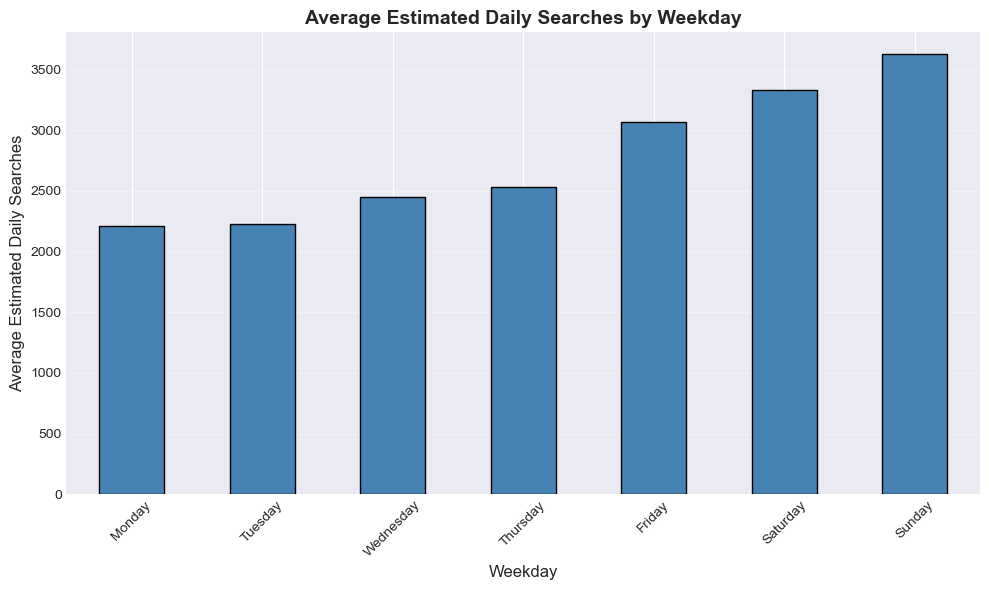


Average searches by weekday:
weekday
Monday       2209.485714
Tuesday      2227.192308
Wednesday    2448.259615
Thursday     2533.466019
Friday       3066.480769
Saturday     3332.086538
Sunday       3625.153846
Name: estimated_daily_searches, dtype: float64


In [12]:
# Average searches by weekday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = df.groupby('weekday')['estimated_daily_searches'].mean().reindex(weekday_order)

plt.figure(figsize=(10, 6))
weekday_avg.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Average Estimated Daily Searches by Weekday', fontsize=14, fontweight='bold')
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Average Estimated Daily Searches', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nAverage searches by weekday:")
print(weekday_avg)


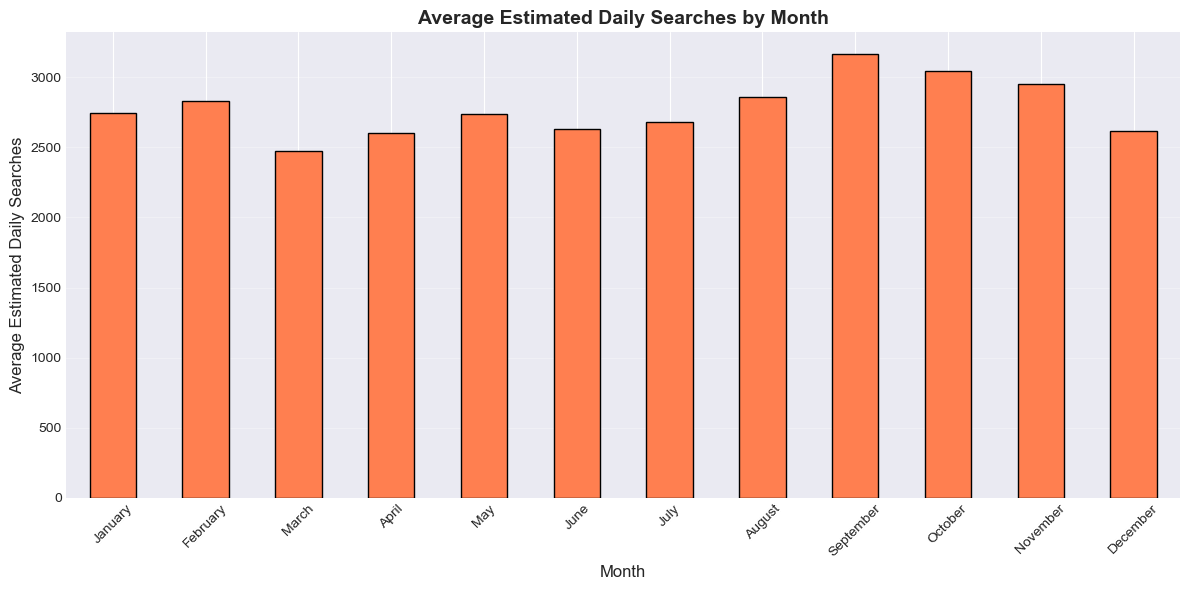


Average searches by month:
month
January      2743.306452
February     2829.526316
March        2475.573770
April        2603.100000
May          2735.467742
June         2632.583333
July         2681.903226
August       2858.196721
September    3162.016667
October      3042.048387
November     2952.474576
December     2619.145161
Name: estimated_daily_searches, dtype: float64


In [13]:
# Average searches by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_avg = df.groupby('month')['estimated_daily_searches'].mean().reindex(month_order)

plt.figure(figsize=(12, 6))
month_avg.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Estimated Daily Searches by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Estimated Daily Searches', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nAverage searches by month:")
print(month_avg)


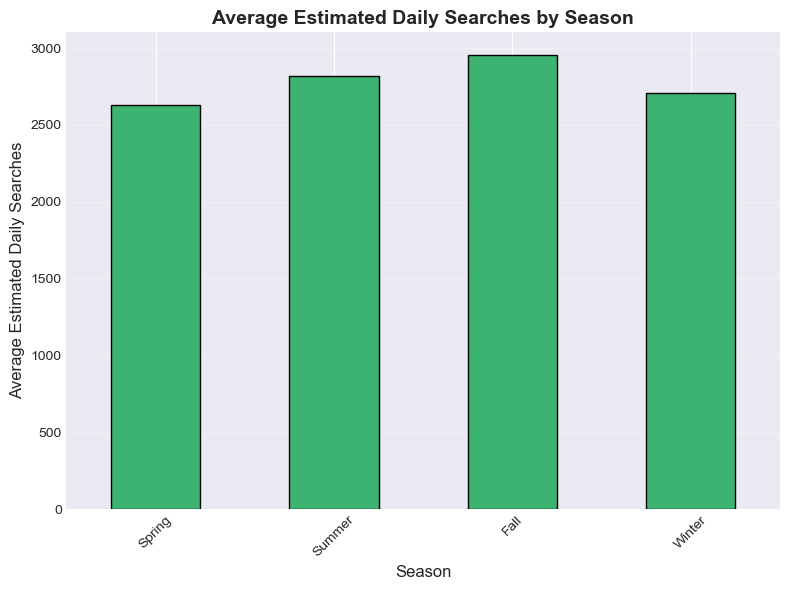


Average searches by season:
season
Spring    2632.664865
Summer    2818.508108
Fall      2955.290503
Winter    2704.988827
Name: estimated_daily_searches, dtype: float64


In [14]:
# Average searches by season
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_avg = df.groupby('season')['estimated_daily_searches'].mean().reindex(season_order)

plt.figure(figsize=(8, 6))
season_avg.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Average Estimated Daily Searches by Season', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Estimated Daily Searches', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nAverage searches by season:")
print(season_avg)


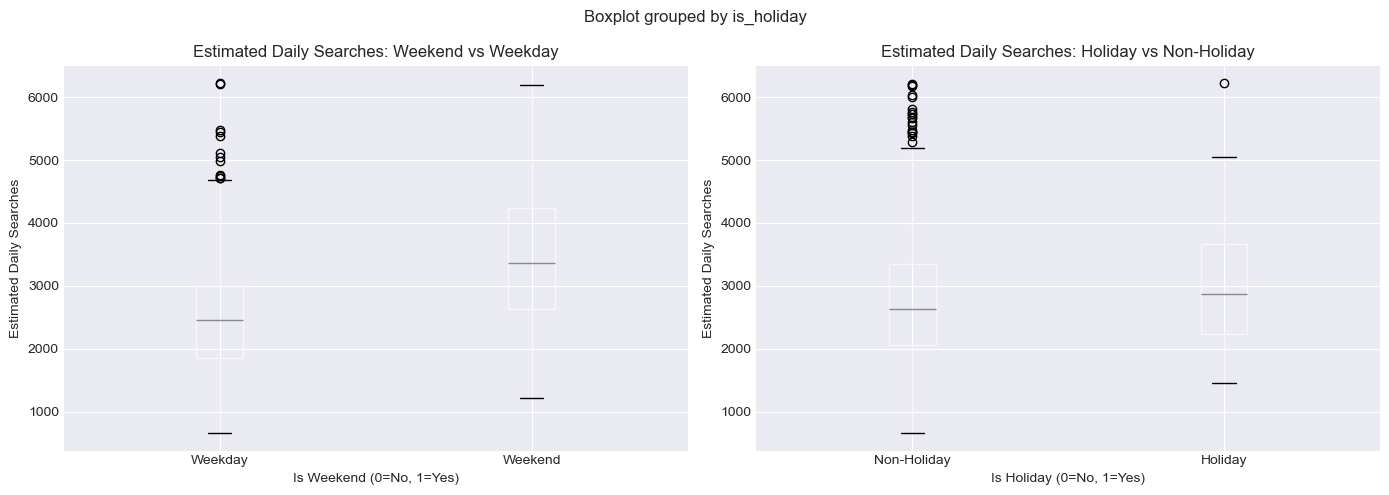


Average searches by weekend status:
is_weekend
0    2496.353846
1    3478.620192
Name: estimated_daily_searches, dtype: float64

Average searches by holiday status:
is_holiday
0    2770.561625
1    3105.428571
Name: estimated_daily_searches, dtype: float64


In [15]:
# Weekend vs Weekday comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df.boxplot(column='estimated_daily_searches', by='is_weekend', ax=axes[0])
axes[0].set_title('Estimated Daily Searches: Weekend vs Weekday')
axes[0].set_xlabel('Is Weekend (0=No, 1=Yes)')
axes[0].set_ylabel('Estimated Daily Searches')
axes[0].set_xticklabels(['Weekday', 'Weekend'])

# Holiday vs Non-Holiday
df.boxplot(column='estimated_daily_searches', by='is_holiday', ax=axes[1])
axes[1].set_title('Estimated Daily Searches: Holiday vs Non-Holiday')
axes[1].set_xlabel('Is Holiday (0=No, 1=Yes)')
axes[1].set_ylabel('Estimated Daily Searches')
axes[1].set_xticklabels(['Non-Holiday', 'Holiday'])

plt.tight_layout()
plt.show()

print("\nAverage searches by weekend status:")
print(df.groupby('is_weekend')['estimated_daily_searches'].mean())
print("\nAverage searches by holiday status:")
print(df.groupby('is_holiday')['estimated_daily_searches'].mean())


## 5. Relationship Analysis: Weather vs Target Variable


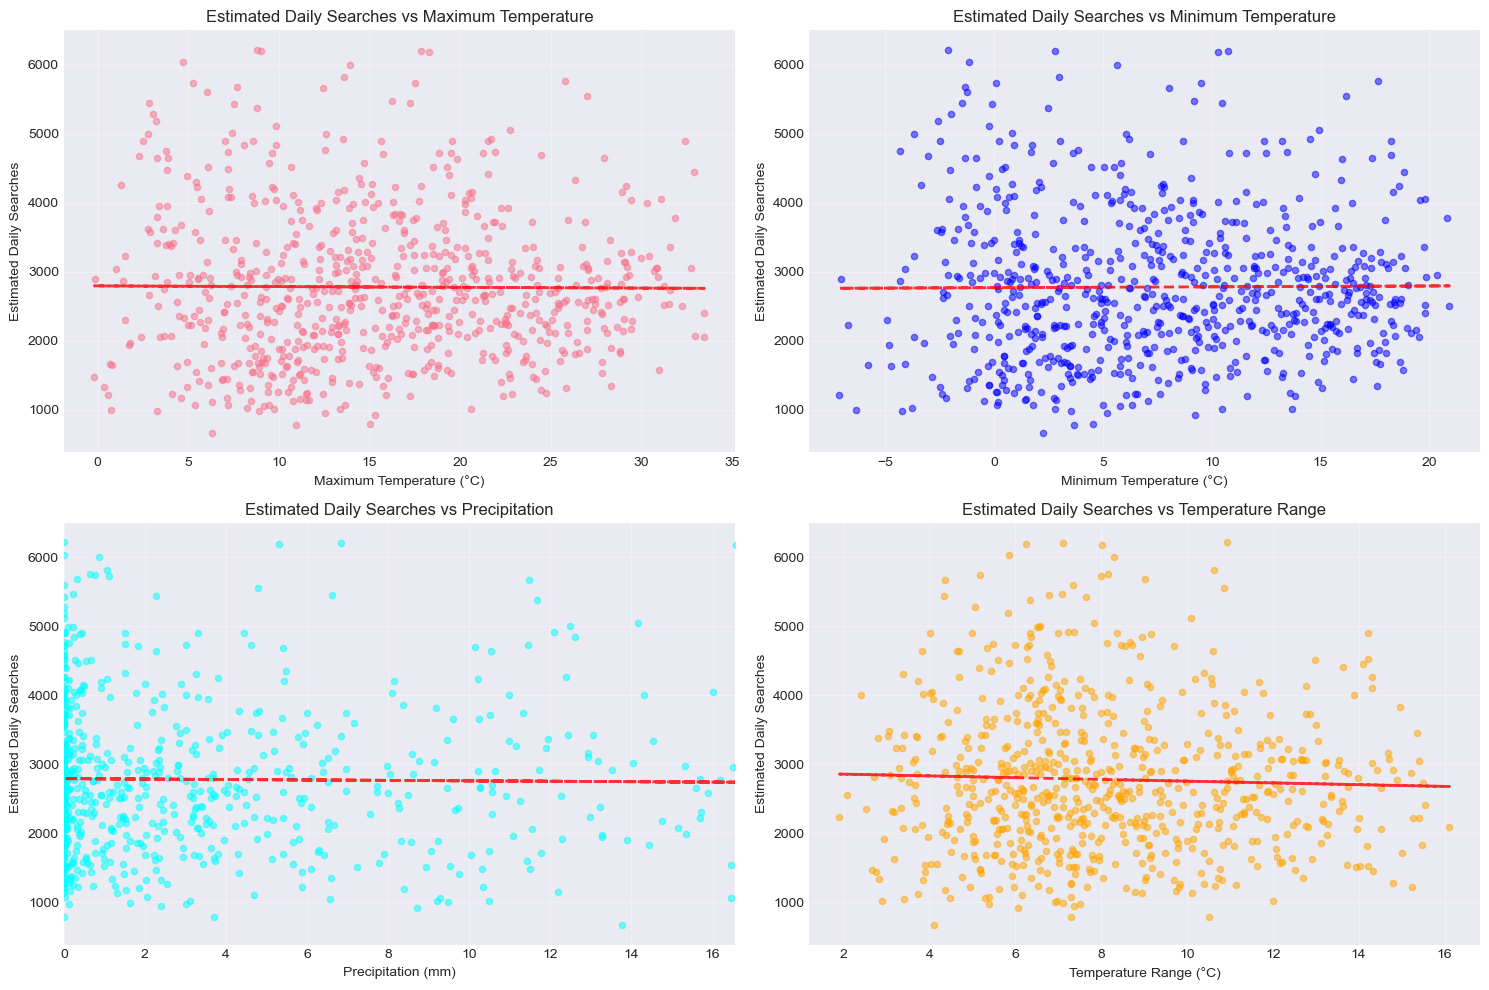

In [16]:
# Scatter plots: Weather features vs Target
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature Max
axes[0, 0].scatter(df['Temp_Max'], df['estimated_daily_searches'], alpha=0.5, s=20)
axes[0, 0].set_title('Estimated Daily Searches vs Maximum Temperature')
axes[0, 0].set_xlabel('Maximum Temperature (°C)')
axes[0, 0].set_ylabel('Estimated Daily Searches')
axes[0, 0].grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df['Temp_Max'], df['estimated_daily_searches'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df['Temp_Max'], p(df['Temp_Max']), "r--", alpha=0.8, linewidth=2)

# Temperature Min
axes[0, 1].scatter(df['Temp_Min'], df['estimated_daily_searches'], alpha=0.5, s=20, color='blue')
axes[0, 1].set_title('Estimated Daily Searches vs Minimum Temperature')
axes[0, 1].set_xlabel('Minimum Temperature (°C)')
axes[0, 1].set_ylabel('Estimated Daily Searches')
axes[0, 1].grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df['Temp_Min'], df['estimated_daily_searches'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['Temp_Min'], p(df['Temp_Min']), "r--", alpha=0.8, linewidth=2)

# Precipitation
axes[1, 0].scatter(df['Precipitation'], df['estimated_daily_searches'], alpha=0.5, s=20, color='cyan')
axes[1, 0].set_title('Estimated Daily Searches vs Precipitation')
axes[1, 0].set_xlabel('Precipitation (mm)')
axes[1, 0].set_ylabel('Estimated Daily Searches')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, df['Precipitation'].quantile(0.95))  # Remove extreme outliers
# Add trend line
z = np.polyfit(df['Precipitation'], df['estimated_daily_searches'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['Precipitation'], p(df['Precipitation']), "r--", alpha=0.8, linewidth=2)

# Temperature Range
axes[1, 1].scatter(df['temp_range'], df['estimated_daily_searches'], alpha=0.5, s=20, color='orange')
axes[1, 1].set_title('Estimated Daily Searches vs Temperature Range')
axes[1, 1].set_xlabel('Temperature Range (°C)')
axes[1, 1].set_ylabel('Estimated Daily Searches')
axes[1, 1].grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(df['temp_range'], df['estimated_daily_searches'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df['temp_range'], p(df['temp_range']), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()


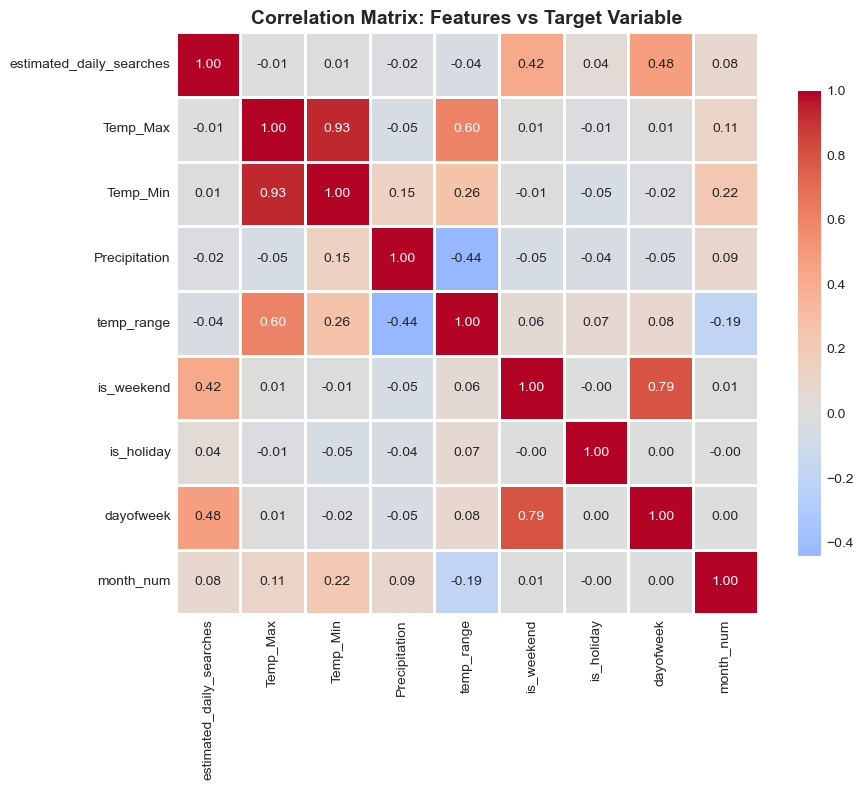


Correlation with estimated_daily_searches:
estimated_daily_searches    1.000000
dayofweek                   0.475033
is_weekend                  0.416794
month_num                   0.078226
is_holiday                  0.043196
Temp_Min                    0.007340
Temp_Max                   -0.007657
Precipitation              -0.017802
temp_range                 -0.035556
Name: estimated_daily_searches, dtype: float64


In [17]:
# Correlation analysis
numeric_cols = ['estimated_daily_searches', 'Temp_Max', 'Temp_Min', 'Precipitation', 
                'temp_range', 'is_weekend', 'is_holiday', 'dayofweek', 'month_num']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Features vs Target Variable', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation with target
print("\nCorrelation with estimated_daily_searches:")
print("=" * 50)
target_corr = correlation_matrix['estimated_daily_searches'].sort_values(ascending=False)
print(target_corr)


## 6. Interaction Effects


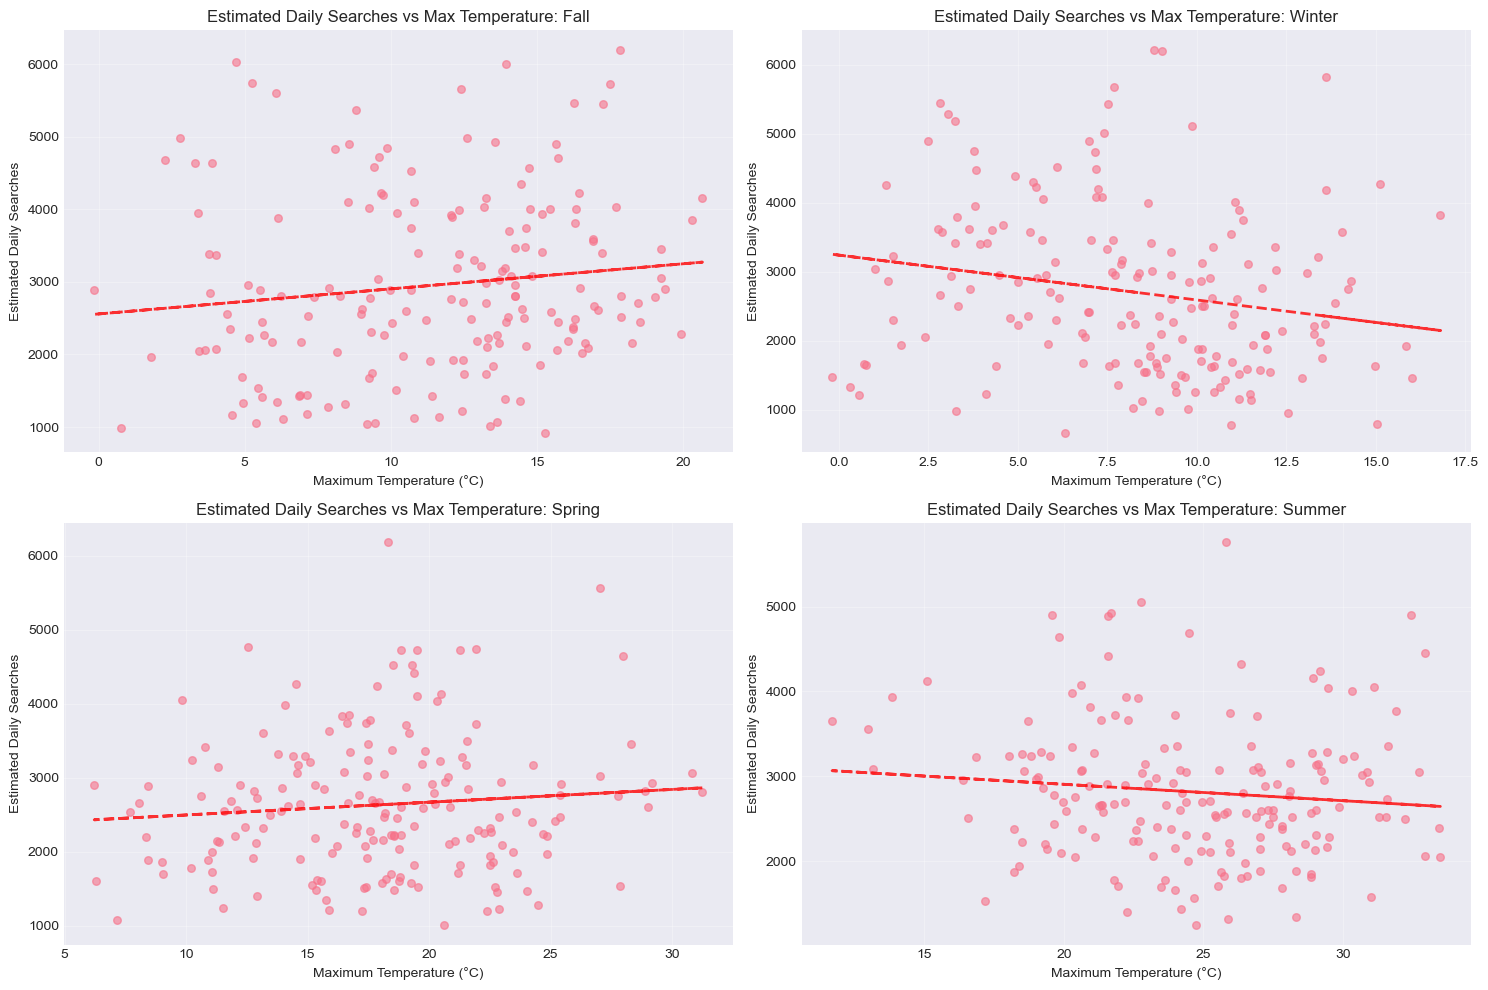

In [18]:
# Temperature vs Searches by Season
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
seasons = df['season'].unique()

for i, season in enumerate(seasons):
    ax = axes[i // 2, i % 2]
    season_data = df[df['season'] == season]
    ax.scatter(season_data['Temp_Max'], season_data['estimated_daily_searches'], 
               alpha=0.6, s=30, label=season)
    ax.set_title(f'Estimated Daily Searches vs Max Temperature: {season}')
    ax.set_xlabel('Maximum Temperature (°C)')
    ax.set_ylabel('Estimated Daily Searches')
    ax.grid(True, alpha=0.3)
    # Add trend line
    if len(season_data) > 1:
        z = np.polyfit(season_data['Temp_Max'], season_data['estimated_daily_searches'], 1)
        p = np.poly1d(z)
        ax.plot(season_data['Temp_Max'], p(season_data['Temp_Max']), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()


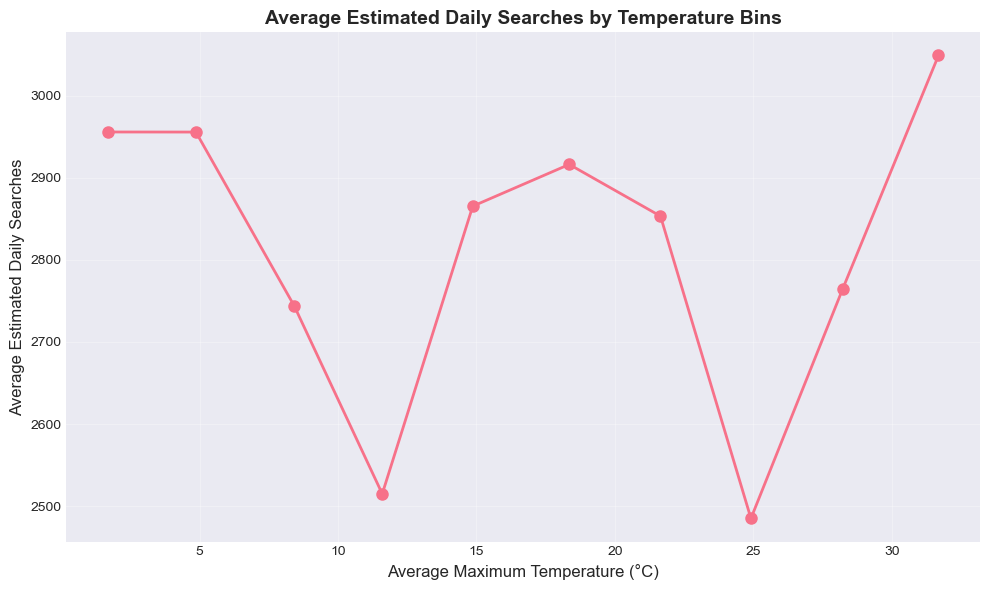

In [19]:
# Average searches by temperature bins
df['temp_bin'] = pd.cut(df['Temp_Max'], bins=10, labels=False)
temp_bin_avg = df.groupby('temp_bin')['estimated_daily_searches'].mean()
temp_bin_centers = df.groupby('temp_bin')['Temp_Max'].mean()

plt.figure(figsize=(10, 6))
plt.plot(temp_bin_centers, temp_bin_avg, marker='o', linewidth=2, markersize=8)
plt.title('Average Estimated Daily Searches by Temperature Bins', fontsize=14, fontweight='bold')
plt.xlabel('Average Maximum Temperature (°C)', fontsize=12)
plt.ylabel('Average Estimated Daily Searches', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Data Quality Checks


In [20]:
# Missing values
print("Missing Values:")
print("=" * 50)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values found!")

# Duplicate dates
print(f"\nDuplicate dates: {df['Day'].duplicated().sum()}")

# Date range
print(f"\nDate range: {df['Day'].min()} to {df['Day'].max()}")
print(f"Total days: {(df['Day'].max() - df['Day'].min()).days + 1}")
print(f"Days in dataset: {len(df)}")


Missing Values:
No missing values found!

Duplicate dates: 0

Date range: 2023-11-13 00:00:00 to 2025-11-11 00:00:00
Total days: 730
Days in dataset: 728


In [21]:
# Outlier detection using IQR method
def detect_outliers(series, name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Outlier Detection (IQR Method):")
print("=" * 50)
numeric_features = ['estimated_daily_searches', 'Temp_Max', 'Temp_Min', 'Precipitation']

for feature in numeric_features:
    outliers, lower, upper = detect_outliers(df[feature], feature)
    print(f"\n{feature}:")
    print(f"  Lower bound: {lower:.2f}")
    print(f"  Upper bound: {upper:.2f}")
    print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"  Outlier range: {outliers.min():.2f} to {outliers.max():.2f}")


Outlier Detection (IQR Method):

estimated_daily_searches:
  Lower bound: 102.62
  Upper bound: 5303.62
  Number of outliers: 19 (2.61%)
  Outlier range: 5378.00 to 6222.00

Temp_Max:
  Lower bound: -8.13
  Upper bound: 39.10
  Number of outliers: 0 (0.00%)

Temp_Min:
  Lower bound: -14.06
  Upper bound: 28.83
  Number of outliers: 0 (0.00%)

Precipitation:
  Lower bound: -8.31
  Upper bound: 14.02
  Number of outliers: 56 (7.69%)
  Outlier range: 14.04 to 39.88


## 8. Summary Statistics


In [22]:
# Final summary
print("Dataset Summary")
print("=" * 60)
print(f"Total records: {len(df)}")
print(f"Date range: {df['Day'].min().date()} to {df['Day'].max().date()}")
print(f"\nTarget Variable (estimated_daily_searches):")
print(f"  Mean: {df['estimated_daily_searches'].mean():.2f}")
print(f"  Median: {df['estimated_daily_searches'].median():.2f}")
print(f"  Std: {df['estimated_daily_searches'].std():.2f}")
print(f"  Min: {df['estimated_daily_searches'].min()}")
print(f"  Max: {df['estimated_daily_searches'].max()}")

print(f"\nWeather Features:")
print(f"  Temp_Max - Mean: {df['Temp_Max'].mean():.2f}°C, Range: {df['Temp_Max'].min():.1f} to {df['Temp_Max'].max():.1f}°C")
print(f"  Temp_Min - Mean: {df['Temp_Min'].mean():.2f}°C, Range: {df['Temp_Min'].min():.1f} to {df['Temp_Min'].max():.1f}°C")
print(f"  Precipitation - Mean: {df['Precipitation'].mean():.2f}mm, Max: {df['Precipitation'].max():.1f}mm")

print(f"\nTime Features:")
print(f"  Weekends: {df['is_weekend'].sum()} days ({df['is_weekend'].sum()/len(df)*100:.1f}%)")
print(f"  Holidays: {df['is_holiday'].sum()} days ({df['is_holiday'].sum()/len(df)*100:.1f}%)")
print(f"  Seasons: {df['season'].value_counts().to_dict()}")

print("\n" + "=" * 60)
print("EDA Complete!")


Dataset Summary
Total records: 728
Date range: 2023-11-13 to 2025-11-11

Target Variable (estimated_daily_searches):
  Mean: 2777.00
  Median: 2635.50
  Std: 1065.39
  Min: 660
  Max: 6222

Weather Features:
  Temp_Max - Mean: 15.65°C, Range: -0.2 to 33.5°C
  Temp_Min - Mean: 7.51°C, Range: -7.1 to 20.9°C
  Precipitation - Mean: 4.12mm, Max: 39.9mm

Time Features:
  Weekends: 208 days (28.6%)
  Holidays: 14 days (1.9%)
  Seasons: {'Spring': 185, 'Summer': 185, 'Fall': 179, 'Winter': 179}

EDA Complete!
